In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/copinghard/Processed Disorders.csv
/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv


In [2]:
import tensorflow as tf
import keras
from keras import layers
from keras import ops
from keras.optimizers import Adam
from keras_hub.tokenizers import compute_word_piece_vocabulary, WordPieceTokenizer
from keras_hub.layers import TokenAndPositionEmbedding
from sklearn.model_selection import train_test_split

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df1 = pd.read_csv('/kaggle/input/copinghard/Processed Disorders.csv')
df2 = pd.read_csv('/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv')


In [5]:
if df1.isna().any().any(): print("DF1")
if df2.isna().any().any(): print("DF2")

DF2


In [6]:
df1['content'] = df1['content'].apply(lambda text: text.replace('\n', ''))

In [7]:
df2 = df2.dropna()
df2 = df2.drop(columns=['Unnamed: 0'], axis=1)

In [8]:
df2['status'] = df2['status'].apply(lambda x: x.lower())

In [9]:
df2 = df2[df2['status'] == 'normal']

In [10]:
df2 = df2.rename(columns={"status" : "label", "statement" : "content"})

In [11]:
df = pd.concat([df1, df2], axis=0, ignore_index=True)

In [12]:
classes = df['label'].unique()
ordinal = {label: i for i,label in enumerate(classes)}
df['label'] = df['label'].apply(lambda label: ordinal[label])
df = df[df['content'].apply(len) <= 512]

In [13]:
df.head()

,content,label
0,life is so pointless without others : does any...,0
15,it hurts : it fucking hurtsit hurts it hurts i...,0
17,different between attachment and love : the ot...,0
22,what is the point of living when you have no o...,0
31,what kind of people do you find yourself attra...,0


In [14]:
train_df, other = train_test_split(
    df,
    test_size = 0.20,
    random_state = 96,
    stratify = df['label']
)
val_df, test_df = train_test_split(
    other,
    test_size = 0.60,
    random_state = 96,
    stratify = other['label']
)

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    train_df['content'].values, train_df['label'].values
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    val_df['content'].values, val_df['label'].values
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    test_df['content'].values, test_df['label'].values
))

In [16]:
auto = tf.data.AUTOTUNE
MAX_SEQLEN = 512

In [17]:
BATCH_SIZE = 128
train_dataset = train_dataset.batch(BATCH_SIZE, num_parallel_calls=auto)
val_dataset = val_dataset.batch(BATCH_SIZE, num_parallel_calls=auto)
test_dataset = test_dataset.batch(BATCH_SIZE, num_parallel_calls=auto)

In [18]:
def train_word_piece(ds, vocab_size=96000, reserved_tokens=["[PAD]", "[UNK]"]):
    word_piece = ds.unbatch().map(lambda x, y: x)
    vocab = compute_word_piece_vocabulary(
        word_piece.batch(1024).prefetch(4),
        vocabulary_size=vocab_size,
        reserved_tokens=reserved_tokens
    )
    return vocab


In [19]:
VOCAB = train_word_piece(train_dataset)

In [21]:
print("Tokens: ", VOCAB[290:310])

Tokens:  ['only', 'hate', 'then', 'make', 'always', 'work', 'back', 'everything', 'take', 'depression', 'better', 'got', 'after', 'way', 'anxious', 'still', 'friends', 'stop', 'she', 'getting']


In [22]:
tokenizer = WordPieceTokenizer(
    vocabulary=VOCAB,
    lowercase=False,
    sequence_length=MAX_SEQLEN
)

In [23]:
input_sentence_ex = train_dataset.take(1).get_single_element()[0][0]
input_tokens_ex = tokenizer(input_sentence_ex)

print("Sentence: ", input_sentence_ex)
print("Tokens: ", input_tokens_ex)
print("Recovered text after detokenizing: ", tokenizer.detokenize(input_tokens_ex))

Sentence:  tf.Tensor(b'woke up with a sore arm : this morning when i woke up i noticed the back of my arm is really sore. it feels like its the muscle. i was totally pain free when i went to bed last night and didnt hurt myself at all. could this be a side effect of lamictal have you experienced similar and did it go away if so i am having so many side effects i want off and never want to take meds ever again i always always have fucking side effects that ruin my life im so over it lol', shape=(), dtype=string)
Tokens:  tf.Tensor(
[ 836  231  208   66 1910 1422   27  204  549  227   74  836  231   74
  708  193  296  195  192 1422  197  236 1910   15  194  330  205  232
  193 1586   15   74  225 1216  402  757  227   74  472  190  493  341
  385  191  506  498  237  234  229   15  312  204  214   66  504  993
  195  969  198  210  683  731  191  335  194  267  369  220  207   74
  230  284  207  439  504  623   74  226  327  191  283  226  190  298
  388  310  328   74  294  294  198  

In [24]:
def format_dataset(sentence, label):
    sentence = tokenizer(sentence)
    return ({"input_ids": sentence}, label)

def make_dataset(dataset):
    dataset = dataset.map(format_dataset, num_parallel_calls=auto)
    return dataset.shuffle(1024).prefetch(16).cache()

In [25]:
train_dataset = make_dataset(train_dataset)
val_dataset = make_dataset(val_dataset)
test_dataset = make_dataset(test_dataset)

In [26]:
VOCAB_SIZE = 96000
EMBED_DIM = 128

In [30]:
def SimpleRNN():
    inputs = layers.Input(shape=(MAX_SEQLEN,), dtype="int", name="input_ids")
    x = TokenAndPositionEmbedding(
        vocabulary_size=VOCAB_SIZE,
        sequence_length=MAX_SEQLEN,
        embedding_dim=EMBED_DIM,
        mask_zero = False,
    )(inputs)
    x = layers.Bidirectional(
        layers.LSTM(
            units = MAX_SEQLEN,
            return_sequences = True,
            seed = 985,
        )
    )(x)
    #attention = layers.MultiHeadAttention(
    #    num_heads=3,
    #    key_dim=128,
    #    dropout = 0.1,
    #)(x, x)
    #x = layers.Add()([x, attention])
    #x = layers.LayerNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x) #gelu, swish, relu
    x = layers.Dropout(0.30)(x)
    outputs = layers.Dense(6, activation='softmax')(x)
    
    return keras.Model(inputs=inputs, outputs=outputs, name="Ganyu")
    

In [31]:
Ganyu = SimpleRNN()

In [32]:
Ganyu.summary()

Model: "Ganyu"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)               │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding_1       │ (None, 512, 128)            │      12,353,536 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 512, 1024)           │       2,625,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,045,062 (57.39 MB)

 Trainable params: 15,045,062 (57.39 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
earlyStopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=4,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
    start_from_epoch=2,
)

modelCheckpoint = keras.callbacks.ModelCheckpoint(
    filepath = 'hutao.keras',
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="auto",
    save_freq="epoch",
)

In [34]:
Ganyu.compile(
    optimizer = Adam(learning_rate = 1e-4), 
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

In [35]:
history = Ganyu.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[earlyStopping])

Epoch 1/10
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 730s 517ms/step - accuracy: 0.3986 - loss: 1.3565 - val_accuracy: 0.5403 - val_loss: 1.1338
Epoch 3/10
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 698s 494ms/step - accuracy: 0.6790 - loss: 0.8965 - val_accuracy: 0.7080 - val_loss: 0.8102
Epoch 5/10
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 699s 495ms/step - accuracy: 0.7303 - loss: 0.7911 - val_accuracy: 0.7156 - val_loss: 0.8024
Epoch 6/10
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 722s 512ms/step - accuracy: 0.7513 - loss: 0.7550 - val_accuracy: 0.7381 - val_loss: 0.7293
Epoch 7/10
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 733s 519ms/step - accuracy: 0.7715 - loss: 0.6851 - val_accuracy: 0.7495 - val_loss: 0.7004
Epoch 8/10
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 702s 497ms/step - accuracy: 0.7885 - loss: 0.6302 - val_accuracy: 0.7643 - val_loss: 0.6599
Epoch 9/10
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 701s 496ms/step - accuracy: 0.7997 - loss: 0.5895 - val_accuracy: 0.7708 - val_loss: 0.6384
Epoch 10/10
1412/1412 ━━━━━━━━━━━━━━━━━━━━ 702s 497ms/step - a

In [37]:
import matplotlib.pyplot as plt

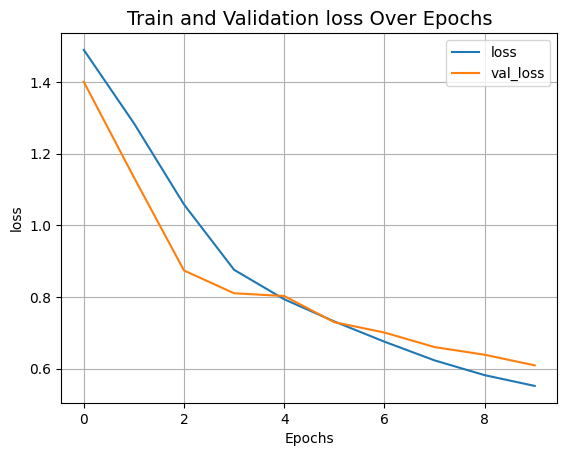

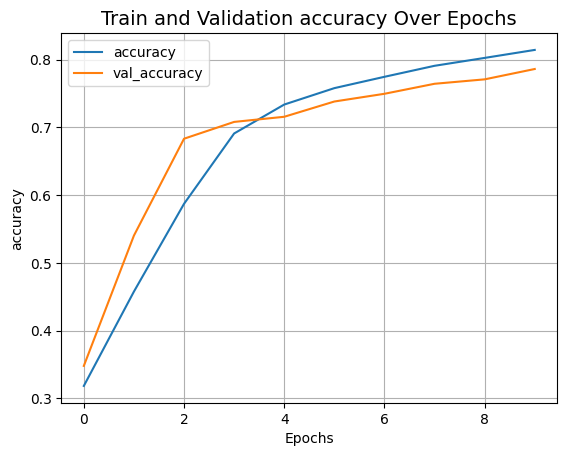

In [38]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

In [39]:
Ganyu.evaluate(test_dataset, batch_size=BATCH_SIZE)

212/212 ━━━━━━━━━━━━━━━━━━━━ 32s 146ms/step - accuracy: 0.7797 - loss: 0.6100


[0.6127749681472778, 0.7807658314704895]